## Testing modified method and normal method
- Using random unitaries for the checking of the models
- Again, the unitary group class is used for random sampling

In [1]:
from qiskit import QuantumCircuit, execute, transpile, Aer 
from qiskit.extensions import UnitaryGate,Initialize
from qiskit.quantum_info import Statevector 
from qiskit.tools.visualization import plot_bloch_vector
from qiskit.tools.visualization import plot_histogram,plot_bloch_multivector  
import numpy as np 
from time import sleep 
import sys 
from scipy.stats import unitary_group 
import matplotlib.pyplot as plt 
%matplotlib inline 

In [2]:
from normal_SPEA import SPEA 
from changed_SPEA import global_max_SPEA 

- Defining Function to test the algorithms

In [13]:
def generate_random_estimation(unitaries,SPE_type,resolution = 40,save = True):
    
    backend = Aer.get_backend('qasm_simulator')
    
    best_costs, errors_in_phases = [] , [] 
    for i,u_rand in enumerate(unitaries):
        print("FOR UNITARY ",i+1)
        # generate the phases and vectors 
        eigen_phases, eigen_vectors = np.linalg.eig(u_rand)
        eigen_phases = np.angle(eigen_phases)
        ep = []
        
        # doing this as phase maybe be negative 
        for k in eigen_phases:
            if k < 0:
                ep.append((k + 2*np.pi)/(2*np.pi))
            else:
                ep.append(k/(2*np.pi))
        eigen_phases = ep
        
        ev1 , ev2 = eigen_vectors[0] , eigen_vectors[1]
        ev1 = ev1 / np.linalg.norm(ev1)
        ev2 = ev2 / np.linalg.norm(ev2)
        
        # generate their corresponding init statevectors 
        sv1 = Initialize(ev1)
        sv2 = Initialize(ev2)
        print("Eigenvectors",ev1,ev2)
        print("Eigenphases",eigen_phases)
        
        
        # run the algorithm 
        if SPE_type == 'original':
            spea = SPEA(resolution = resolution, max_iters = 10, unitary = u_rand,error = 4)
        else:
            spea = global_max_SPEA(resolution = resolution, max_iters = 10, unitary = u_rand,error = 4)
        result = spea.get_eigen_pair(backend = backend, progress = False, randomize = True)
        # get the results 
        res_state = result['state']
        res_theta = result['theta']
        sv_res = Initialize(res_state)
        print("Result",result)
        print("Phase returned :",res_theta)
        # get the dot products 
        d1 = np.linalg.norm(np.dot(ev1, res_state.conjugate().T))**2 
        d2 = np.linalg.norm(np.dot(ev2, res_state.conjugate().T))**2 
    
        # make a bloch sphere
        qc = QuantumCircuit(2)
        qc = qc.compose(sv_res,qubits = [0])
        if d1 > d2:
            print("Best overlap :",d1)
            # it is closer to the first
            qc = qc.compose(sv1,qubits = [1])
            best_costs.append(result['cost'])
            errors_in_phases.append(abs(res_theta - eigen_phases[0]))
        else:
            # it is closer to the second
            print("Best overlap :",d2)
            qc = qc.compose(sv2,qubits = [1])
            best_costs.append(result['cost'])
            errors_in_phases.append(abs(res_theta - eigen_phases[1]))
        print("Bloch Sphere for the states...")
        s = Statevector.from_instruction(qc)
        display(plot_bloch_multivector(s))
        
    if SPE_type == 'original':
        plt.title("Experiments over Random Matrices for original SPEA",fontsize= 16)
    else:
        plt.title("Experiments over Random Matrices for modified SPEA",fontsize= 16)
    
    plt.xlabel("Experiment Number")
    plt.ylabel("Metric value")
    plt.plot([i for i in range(len(unitaries))], best_costs, label = 'Best Costs', alpha = 0.5, color = 'r',marker='o',linewidth = 2)
    plt.plot([i for i in range(len(unitaries))], errors_in_phases, label = 'Corresponding Error in Phase',linewidth = 2, alpha = 0.5, color = 'b',marker='s') 
    plt.legend()
    plt.grid()
    if save:
        if SPE_type == 'original':
            plt.savefig("Random Estimation for Original SPE.jpg",dpi = 200)
        else:
            plt.savefig("Random Estimation for Modified SPE.jpg",dpi = 200)



### Defining matrices

In [14]:
unitaries = []
for i in range(6):
    u = unitary_group.rvs(2)
    unitaries.append(u)
print("Unitaries :",unitaries) 

Unitaries : [array([[ 0.15639952-0.56350455j,  0.49585066-0.64197659j],
       [-0.1523053 +0.79674645j,  0.31843965-0.49050421j]]), array([[-0.10277115-0.08611163j, -0.62385135-0.76995608j],
       [ 0.52223136+0.84219789j, -0.04756352-0.12535882j]]), array([[-0.31838074+0.15660044j, -0.77794427-0.51856795j],
       [-0.91950359+0.16918379j,  0.23065467+0.2696079j ]]), array([[ 0.29732662+0.59717568j, -0.49819501+0.55387708j],
       [-0.12557745-0.73430811j, -0.57021479+0.34623259j]]), array([[-0.2922255 +0.24967856j, -0.90738862-0.17003167j],
       [ 0.84208158-0.3783695j , -0.34268801-0.1740691j ]]), array([[ 0.82090059+0.38138535j, -0.25847092-0.33743179j],
       [ 0.42425507+0.02598203j,  0.77479537+0.46800076j]])]


## Testing for the First Algorithm 

FOR UNITARY  1
Eigenvectors [0.7446128 +0.j         0.15502964-0.64924386j] [-0.15502964-0.64924386j  0.7446128 +0.j        ]
Eigenphases [0.6654527932238252, 0.9692801853637787]
Maximum iterations reached for the estimation.
Terminating algorithm...
Result {'cost': 0.634765625, 'theta': 0.14285714285714285, 'state': array([-0.0173472 -0.93620298j,  0.34182292-0.07987576j])}
Phase returned : 0.14285714285714285
Best overlap : 0.7538280117491042
Bloch Sphere for the states...


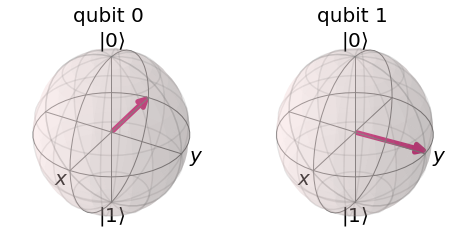

FOR UNITARY  2
Eigenvectors [ 0.71908166+0.j         -0.04371695-0.69354913j] [0.04371695-0.69354913j 0.71908166+0.j        ]
Eigenphases [0.4223470953705551, 0.8809357982052399]
Maximum iterations reached for the estimation.
Terminating algorithm...
Result {'cost': 0.572265625, 'theta': 0.1096938775510204, 'state': array([-0.57339854+0.3076455j , -0.22632978-0.72480562j])}
Phase returned : 0.1096938775510204
Best overlap : 0.9807434112978293
Bloch Sphere for the states...


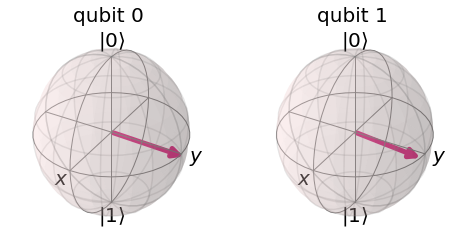

FOR UNITARY  3
Eigenvectors [ 0.80223168+0.j         -0.55332095-0.22418801j] [0.55332095-0.22418801j 0.80223168+0.j        ]
Eigenphases [0.4974007552770966, 0.06721428224203971]
Maximum iterations reached for the estimation.
Terminating algorithm...
Result {'cost': 0.8203125, 'theta': 0.37499999999999994, 'state': array([0.95842405+0.01657926j, 0.17083434-0.22795635j])}
Phase returned : 0.37499999999999994
Best overlap : 0.5578766700829334
Bloch Sphere for the states...


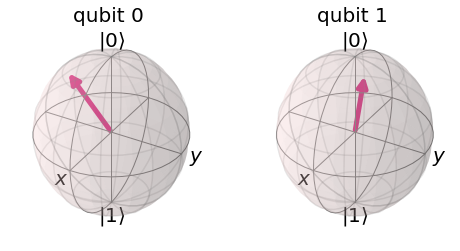

FOR UNITARY  4
Eigenvectors [0.87130636+0.j         0.21387391-0.44168222j] [-0.21387391-0.44168222j  0.87130636+0.j        ]
Eigenphases [0.12650551101865204, 0.463121840049731]
Maximum iterations reached for the estimation.
Terminating algorithm...
Result {'cost': 0.853515625, 'theta': 0.20790816326530612, 'state': array([0.52445656-0.82114206j, 0.02327647+0.2238956j ])}
Phase returned : 0.20790816326530612
Best overlap : 0.5638485758944042
Bloch Sphere for the states...


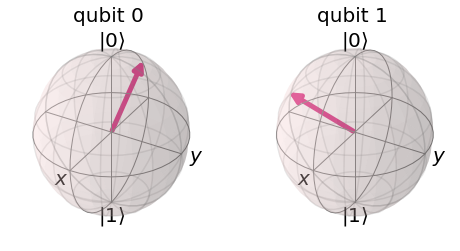

FOR UNITARY  5
Eigenvectors [0.78268418+0.j         0.18617519-0.59392278j] [-0.18617519-0.59392278j  0.78268418+0.j        ]
Eigenphases [0.2829267147973769, 0.6793446386376206]
Maximum iterations reached for the estimation.
Terminating algorithm...
Result {'cost': 0.9609375, 'theta': 0.6824776785714285, 'state': array([0.7860672 +0.07411148j, 0.14343503+0.59668437j])}
Phase returned : 0.6824776785714285
Best overlap : 0.8526482502434208
Bloch Sphere for the states...


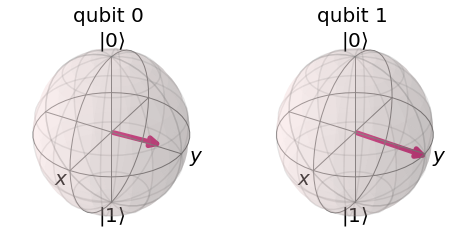

FOR UNITARY  6
Eigenvectors [ 0.7465463+0.j         -0.2761395+0.60532272j] [0.2761395+0.60532272j 0.7465463+0.j        ]
Eigenphases [0.007482524051964122, 0.14821910430163918]
Maximum iterations reached for the estimation.
Terminating algorithm...
Result {'cost': 0.994140625, 'theta': 0.04318513119533528, 'state': array([ 0.37682892+0.33308034j, -0.03350109+0.86367536j])}
Phase returned : 0.04318513119533528
Best overlap : 0.6625033299772186
Bloch Sphere for the states...


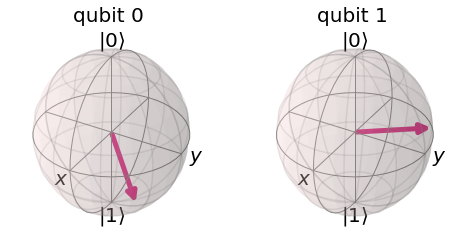

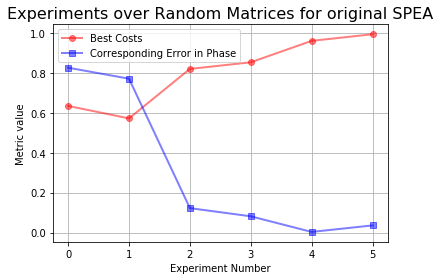

In [15]:
generate_random_estimation(unitaries,'original',resolution=15)

## Testing for the Modified Algorithm

FOR UNITARY  1
Eigenvectors [0.7446128 +0.j         0.15502964-0.64924386j] [-0.15502964-0.64924386j  0.7446128 +0.j        ]
Eigenphases [0.6654527932238252, 0.9692801853637787]
Maximum iterations reached for the estimation.
Terminating algorithm...
Result {'cost': 0.9765625, 'theta': 0.6900510204081631, 'state': array([-0.78243519-0.04810691j,  0.36771246+0.50026837j])}
Phase returned : 0.6900510204081631
Best overlap : 0.8018457033156701
Bloch Sphere for the states...


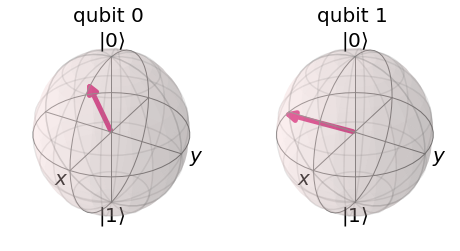

FOR UNITARY  2
Eigenvectors [ 0.71908166+0.j         -0.04371695-0.69354913j] [0.04371695-0.69354913j 0.71908166+0.j        ]
Eigenphases [0.4223470953705551, 0.8809357982052399]
Maximum iterations reached for the estimation.
Terminating algorithm...
Result {'cost': 0.994140625, 'theta': 0.4174107142857142, 'state': array([0.73067097-0.07710662j, 0.14580237-0.66250749j])}
Phase returned : 0.4174107142857142
Best overlap : 0.9630713369555141
Bloch Sphere for the states...


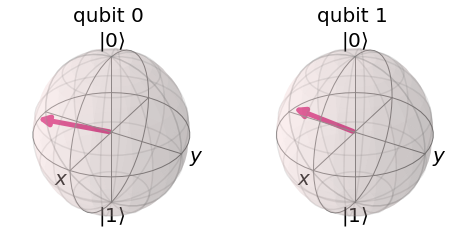

FOR UNITARY  3
Eigenvectors [ 0.80223168+0.j         -0.55332095-0.22418801j] [0.55332095-0.22418801j 0.80223168+0.j        ]
Eigenphases [0.4974007552770966, 0.06721428224203971]
Maximum iterations reached for the estimation.
Terminating algorithm...
Result {'cost': 0.763671875, 'theta': 0.9075255102040816, 'state': array([ 0.2263452 -0.35540281j, -0.35445867+0.8347549j ])}
Phase returned : 0.9075255102040816
Best overlap : 0.719366018572254
Bloch Sphere for the states...


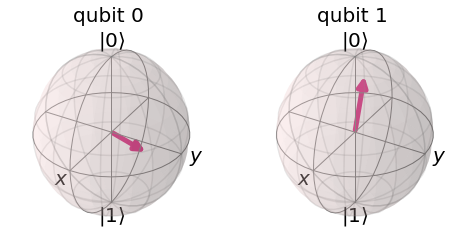

FOR UNITARY  4
Eigenvectors [0.87130636+0.j         0.21387391-0.44168222j] [-0.21387391-0.44168222j  0.87130636+0.j        ]
Eigenphases [0.12650551101865204, 0.463121840049731]
Maximum iterations reached for the estimation.
Terminating algorithm...
Result {'cost': 0.912109375, 'theta': 0.5638950892857142, 'state': array([-0.19486888-0.45575089j,  0.75997861-0.42041617j])}
Phase returned : 0.5638950892857142
Best overlap : 0.9452538508205099
Bloch Sphere for the states...


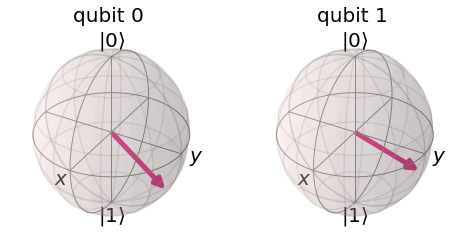

FOR UNITARY  5
Eigenvectors [0.78268418+0.j         0.18617519-0.59392278j] [-0.18617519-0.59392278j  0.78268418+0.j        ]
Eigenphases [0.2829267147973769, 0.6793446386376206]
Maximum iterations reached for the estimation.
Terminating algorithm...
Result {'cost': 0.97265625, 'theta': 0.6808035714285713, 'state': array([-0.55765763-0.47122731j,  0.43941082-0.52333634j])}
Phase returned : 0.6808035714285713
Best overlap : 0.955938778895373
Bloch Sphere for the states...


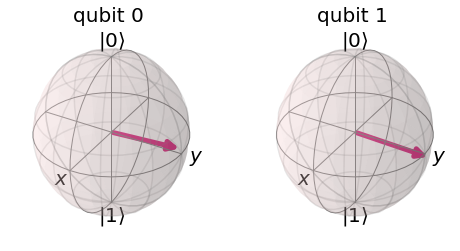

FOR UNITARY  6
Eigenvectors [ 0.7465463+0.j         -0.2761395+0.60532272j] [0.2761395+0.60532272j 0.7465463+0.j        ]
Eigenphases [0.007482524051964122, 0.14821910430163918]
Maximum iterations reached for the estimation.
Terminating algorithm...
Result {'cost': 0.9921875, 'theta': 0.03443877551020408, 'state': array([0.87547598+0.22480028j, 0.0027893 +0.42778367j])}
Phase returned : 0.03443877551020408
Best overlap : 0.83361154396033
Bloch Sphere for the states...


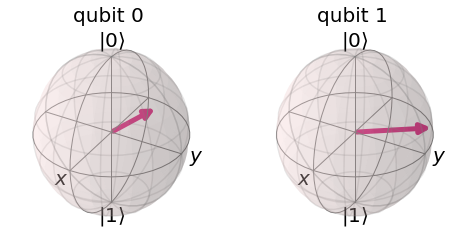

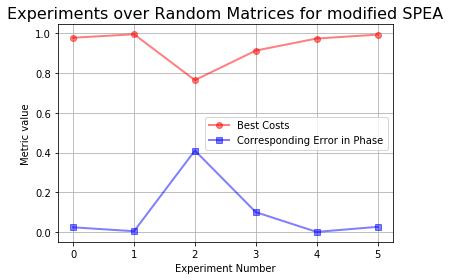

In [16]:
generate_random_estimation(unitaries,'modified',resolution=15)

### Inference
- Both of the methods use the **alternate approach** in them
- We can clearly see that the modified and the original algorithm behave at par with each other